<h1>Como as Redes Neurais Convolucionais (CNN ou Conv-Nets) modernas fazem a pré-classificação dos dados</h1>

<h2>1 Introdução</h2>
<p>Quando estudamos Redes Neurais Convolucionais somos apresentados à arquitetura geralmente dividida em duas partes:     a primeira trata-se de um empilhamento de camadas de convolução e pooling (ConvPool), e, após empilhar duas ou três dessas estruturas tem-se o que os autores chamam de camada completamente concectada.</p>
<p>Quando da proposta inicial das redes neurais convolucionais como a AlexNet, pensou-se nas camadas de convolução+pooling (ConvPool) para extração de características (Geração de Mapas de características ou <i>Feature Maps</i>) e após essa extração, os dados seriam submetidos à uma camada completamente conectada semelhante à uma Multi Layer Perceptron que seria responsável por fazer a classificação das características extraídas anteriormente.</p>
<p>Multi Layer Perceptrons recebem como parâmetros um vetor (unidimensional) de entrada e outro de pesos, e fazem a multiplicação de cada entrada por cada peso para submete-los à sua função de ativação. Porém o resultado das camadas ConvPool são diversas matrizes (um vetor de 3 dimensões, na verdade) onde cada matriz na terceira dimensão correponde à uma camada da entrada submetidas à um dos diversos filtros dentro da rede. Muitos cientistas resolvem este problema de forma muito fácil, apenas achatando a saída da última ConvPool antes de submetê-la à camada completamente conectada. Isso funciona para diversas aplicações de classificação como a apresentada <a href="https://github.com/alsgil13/TCCFatec/blob/master/01_SimpleConvMNIST.ipynb">neste exemplo</a>.</p>
<h3>1.1 Objetivo</h3>
<p>O Objetivo deste trabalho é demonstrar quais são as consequências decorrentes do achatamento dos Mapas de Características e propor uma abordagem diferente, como já é utilizado amplamente nos modelos de redes neurais convolucionais modernas. Será demostrada a diferença entre a pré-classificação dos mapas de características feitas através de uma camada completamente conectada conforme descrito anteriormente e a mesma operação realizada por convoluções subdimensionadas (Convolução 1x1).</p>
<h4>1.1.1 Escopo</h4>
<p>Para tratar o tema de forma mais restrita foram ignoradas partes importantes presentes nas arquiteturas de redes neurais convolucionais como Dropout, BatchNormalization e até mesmo funções de ativação e a camada de classificação. Isso foi feito, principalmente, para tentar mostrar de forma clara a criação dos mapas de caracteríticas, bem como para simplificar o código apresentado que, para manter a legibilidade, não buscou otimização da performance computacional.</p>
<h3>1.2 Metodologia</h3>
<p>Foram criadas 3 funções principais que serão as camadas da Rede Neural convolucional sendo: conv, maxpool e fullyconnV que serão responsáveis, respectivamente por: fazer a convolução, fazer a subamostragem (pooling), e fazer a pré-classificação (camada completamente conectada) de duas formas diferentes. Além dessas, foram criadas duas outras funções acessórias para a geração aleatória dos filtos e para exportação dos resultados em imagens.</p>
<h4>1.2.1 Materiais e Métodos</h4>
<p>Para a cração do algoritmos foi utilizada a linguagem Python (Versão 3.7.3), o presente trabalho foi escrito utilizando o Jupyter Notebook. Fora utilizadas as seguintes bibliotecas do python:</p>
<table>
    <tr>
        <th>Biblioteca</th>
        <th>Uso</th>
    </tr>
    <tr>
        <td>NumPy</td>
        <td>Toda a base do algoritmos que será apresentado é feita por arrays do numpy (numpy.ndarray)</td>
    </tr>
    <tr>
        <td>Math</td>
        <td>Foi utilizada apenas uma função de arredondamento</td>
    </tr>
    <tr>
    <td>Matplotlib</td>
    <td>Utilizada para vizualização dos Mapas de Características</td>
    </tr>
    <tr>
    <td>PIL</td>
    <td>Utilizada para importação de imagens oq eu nos permite trabalhar com qualquer imagem</td>
    </tr>
    
    
</table>
        

In [1]:
import numpy as np
import math
import matplotlib
from matplotlib import pyplot
from PIL import Image

<h4>1.2.2 Exportação dos Resultados</h4>
<p> Os resultados após cada transformação serão salvos em pastas distintas como imagens (formato *.jpg). Estes resultados serão comparados mais à frente para evidenciar o que acontece a cada transformação, e, principalmente, a diferença entra a camada completamente conectada tradicional (baseada na MLP) e a moderna (composta de convoluções subdimensionadas). Foi criada a função abaixo para auxiliar-nos nesta tarefa de exportação. 
</p>

In [2]:
def exp_results(inp,nm_dir):
    import datetime
    import os
    os.makedirs("./out/"+nm_dir)
    nome = "out/"+nm_dir+"/"
    i = 0
    for p in np.rollaxis(inp, -1):
    #    nome = nome+str(i)
        fig0, ax0 = pyplot.subplots(nrows=1, ncols=1)
        ax0.imshow(p).set_cmap("gray")
        ax0.set_title("Image #"+str(i))
        ax0.get_xaxis().set_ticks([])
        ax0.get_yaxis().set_ticks([])
        pyplot.savefig(nome+str(i)+".jpg", bbox_inches="tight")
        pyplot.close(fig0)
        i = i+1

<h2>2 Redes Neurais Convolucionais</h2>
<p>Redes Neurais convolucionais como a <a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">AlexNet</a> são compostas de camadas de convolução seguidas de camadas de pooling, após o empilhamento de algumas destas sequências os dados obtidos são submetidos à uma camada completamente conectada, como demonstrado no figura a seguir:<br>
<img src="img/CNN.png">
</p>

<p>Figura 1: Exemplo simples de uma Rede Neural Convolucional<br>Fonte: Criado pelo autor utilizando <a href="https://alexlenail.me/NN-SVG/LeNet.html">esta ferramenta </a></p>

<p>Na arquitetura apresentada anteriormente temos a entrada repreentada poor uam matriz (3x128x128) que é equivalente à uma imagem colorida de 128x128 pixels. Após a primeira convolução passamos a ter 12 mapas de características de mesma dimensão (128x128px), neste mapas é aplicada uma técnica de pooling para diminuir o seu tamanho e ganharmos eficiência, passamos a ter então 12 mapas de características de 64x64 pixels. Esta operação se repete mais uma vez cuminando ao fim do empilhamento de Convoluções + Pooling em 24 mapas de características de 32x32 pixels. Estes dados serão então submetidos à duas Camadas Completamente Conectadas.
</p>
<p>Geralmente o número de neurônios da última camada completamente conectada corresponde ao número de classes possíveis de se classificar o dataset analisado. Na figura a seguir, que apresenta a arquitetura da AlexNet, podemos notar que sua última cadamada completamente conectada tem 1000 neurônios, pois fora porposta pra clissificar um dataset de 1000 classes diferentes de imagens. <br> <img src="img/AlexNet.png"></p>
<p>Figura 2: Arquitetura da AlexNet<br>Fonte: <a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">ImageNet Classification with Deep ConvolutionalNeural Networks</a></p>

<h3>2.1 Filtros</h3>


<p>Filtros são pequenas matrizes de dados preenchidas com números que serão utilizados pela função 'conv' e 'fullyconnV' para multiplicar suas entradas. Em geral, neste trabalho, cada filtro apresenta duas dimensões iguais, organizamos os filtros em bancos de filtros (filter bank), formando assim um vetor de 3 dimensões, onde as duas primeiras dimensões correpondem ao tamanho dos filtros e a última dimensão à quantidade deles. Para a utilização da camada completamente conectada clássica esta matriz de 3 dimensões deve ser achatada em apenas 1 dimensão.</p>

In [3]:
#Gerador de filtros aleatórios
#
#    retorna um determinado numero de filtros (num), os valores inseridos em cada filtro obedecem uma distribução normal
#    ao redor de uma média (md), desvio padrão (stdv) e tamanho (sz) definidos. 
def filtergen(num,md=0,stdv=0.02,sz=4):
    filter_bank = []
    for i in range(num):
        filtro = np.random.normal(md,stdv,[sz,sz])
        filter_bank.append(filtro)
    
    filter_bank = np.array(filter_bank).swapaxes(0,-1)
    return filter_bank

<h3>2.2 Camada de Convolução</h3>
<p>
Um processo de convulução é um processo iterativo de multiplicação de matrizes. Uma matriz de entrada tem parte dos seus valores multiplicados pelos valores de um filtro, o filtro geralmente é menor do que a matriz de entrada, para que ele possa atuar sobre toda a entrada ele deve se deslocar um numero de passos em cada eixo, chamamos este passo de stride.<br>
Após multiplicar todos os valores de uma região da matriz (chamada de campo receptivo ou <i>Receptive Field</i>) é feito um somatório da matriz resultante, este montante é adicionado à uma nova matriz cahamda de Mapa de Características (ou <i>Feature Map</i>).<br>
A animação abaixo ilustra este processo:
<img src="img/conv.gif">
Figura 3: Exemplo animado de uma convolução<br>
Fonte: <a href="https://giphy.com/gifs/blog-daniel-keypoints-i4NjAwytgIRDW">https://giphy.com/gifs/blog-daniel-keypoints-i4NjAwytgIRDW</a>
</p>


<p> A função abaixo faz o processo descrito anteriormente, note que este processo deve ser feito para cada matris de entrada, ou seja, se a entrada consiste de uma matriz de duas dimensões, o processo é feito diretametne sobre esta entrada, caso a entrada seja uma coleção de matrizes de duas dimensões (ou seja, uma matriz de 3 dimensões) a função faz uma chamada recursiva para cada uma das matrizes na terceira dimensão.
</p>

In [4]:

#Recebe um numpy.ndarray

def conv(inp,fbank,s=1,p=0,ch_ord="channel_last"):
    
    #FORMATO DE ENTRADA PADÃO (channel_last):
    #    ndim = 3: (Altura, Largura, Profundidade)
    #    ndim = 2: (Altura, Largura)
    
    # caso a podem da entrada esteja invertida e tenha sido informado nos parâmetros  
    # o if abaixo faz o ajuste
    if ch_ord == "channel_first":
        inp = np.array(inp).swapaxes(0,-1)
    
    
    # Tamanho do filtro
    # Pega altura, largura e profundidade do filtro
    af, lf, pf = fbank.shape
    
    if(inp.ndim == 2):
    # Pega altura, largura e profundidade da entrada de duas dimensões
        ai, li = inp.shape
        # fazer a convolução
        
        #Calcula o tamanho do feature map que será gerado:
        a_mp_sz = int(math.ceil((ai-af+2*p)/s+1)) #altura do mapa de características que será gerado
        l_mp_sz = int(math.ceil((li-lf+2*p)/s+1)) #largura do mapa de características que será gerado
        
        #Cria a lista que deverá ser o banco de feature maps
        fmap_bank = []
        
        #Convolução:
        for filtro in np.rollaxis(fbank,-1):
            #cria feature map vazio:
            fmap = np.empty([a_mp_sz,l_mp_sz], dtype = float)
            #Define os apontadores para 0
            k=[0,0]
            for i in range(0,a_mp_sz,s):
                for j in range(0,l_mp_sz,s):
                    #Neste momento selecionaremos a parte da entrada que será submetida ao filtro nesse passo
                    fatia = inp[i:i+af,j:j+lf]
                    #--------------------------------------------------------------------
                    fmap[k[0],k[1]] = (fatia*filtro).sum()
                    #--------------------------------------------------------------------
                    k[1] += 1
                k[1] = 0
                k[0] += 1
            fmap_bank.append(fmap)
        
        npfmap_bank = np.dstack(fmap_bank)
        
        return npfmap_bank
        
    else:
        multi_fmap_bank = []
        # Chamada recursiva iterativa:
        for camada in np.rollaxis(inp,-1):
            multi_fmap_bank.append(conv(camada,fbank,s,p))
            
        multi_fmap_bank = np.dstack(multi_fmap_bank)
        return multi_fmap_bank
    

<h3>2.3 Pooling</h3>
<p>
A função do Pooling (traduzido de forma grosseira como subamostragem) é reduzir o tamanho das entradas e, dessa forma, promover economia computacnonal. Como a cada convulução os dados ganham profundidade, se as matrizes mantiverem o mesmo tamanho, o custo computacional aumentará exponencialmente. O Pooling parte do princípio que dados vizinhos são capazes de sumarizar a informação de uma reginão da matriz através de unico valor, seja o valor máximo um uma média dos valores da matriz parcial.
Veja o exemplo a seguir:
<img src="img/maxpool.png">
Figura 4: Exemplo de Pooling pelo valor máximo<br>
Fonte: <a href="http://cs231n.github.io/convolutional-networks/">http://cs231n.github.io/convolutional-networks/ </a><br>
Neste exemplo uma matriz 4x4 foi diminuída à uma matriz 2x2 mantendo o valor máximo de cada uma de suas regiões (compostas por pedaços mendindo 2x2 da matriz original).<br>
Na função 'maxpool' abaixo este procedimetno é feito desta forma, selecionando o valor máximo de cada região da matriz original para sumarizar os dados daquela região.
</p>

In [5]:
def maxpool(fmap_bank,sz=2,s=2):
    #fmap_axis_sz = int(fmap_bank[0].size ** (1/2))
    
    a_fmap, l_fmap, p_fmap = fmap_bank.shape
    a_rfmap = int((a_fmap - sz)/s)+1
    l_rfmap = int((l_fmap - sz)/s)+1
    rfmap_bank = []
    
    #print("Tamanho do eixo: "+str(fmap_axis_sz))
    for fmap in np.rollaxis(fmap_bank, -1):
        rfmap = np.empty([a_rfmap,l_rfmap], dtype = float)
        k = np.array([0,0], dtype = int)
        for i in range(0,(a_fmap-sz+1),s):
            for j in range(0,(l_fmap-sz+1),s):
                #Neste momento selecionaremos a parte da entrada que será submetida ao pooling nesse passo
                fatia = fmap[i:i+sz,j:j+sz]
                #Poolando
                #--------------------------------------------
                rfmap[k[0],k[1]] = ((fatia).max())
                k[1] += 1
                #--------------------------------------------
            k[1] = 0
            k[0] += 1
        rfmap_bank.append(rfmap)
    rfmap_bank = np.dstack(rfmap_bank)
    return np.array(rfmap_bank)


<h3>2.4 Camada Completamente Conectada</h3>
<p>Como dissemos anteriormente existem duas maneiras distintas de se executar a camada complemtanete conectada de uma rede neural coonvolucional. A primeira que, neste trabalho, é denominada 'clássica' onde os dados da entrada são achatados e multiplicados por todos os valores de um vetor de uma dimensão, e a forma 'moderna' que é fazer esta operação através da convolução das entradas por filtros de tamanho 1x1. A função abaixo foi escrita para fazer das duas formas apresentadas.

</p>

In [6]:
# "Camada Completamente Conectada"
def fullyconnV(inp,fcl_fbnk,p=0,mode="modern"):
    if mode == "modern":
        if (fcl_fbnk[0].shape[0]) == 1:
            return conv(inp,fcl_fbnk,s=1)
        else:
            print("Para utilizar o modo 'modern' você deve fornecer um banco de filtros de 3 dimensões (1x1xN)")
    elif mode == "classic":
        if fcl_fbnk.ndim == 1:
            feature_vector = []
            for i in np.rollaxis(inp,-1):
                i = i.flatten()
                for f in fcl_fbnk:
                    feature_vector.append((i*f))
            return np.array(feature_vector).reshape(-1)
        else:
            print("Para utilização do modo 'classic' você deve fonecer um filtro de apenas uma dimensão (vetor)")
            
    
    


<h2>3 Submetendo imagens reais às estruturas apresentadas</h2>
<p>Tendo apresentado as estruturas na seção anterior, começaremos agora a trabalhar com imagens reais submetendo-as às camadas de convolução e pooling duas vezes e depois, submetendo o resultado destes processamento à camada completamente conectada 'clássica' e moderna. Analisaremos os resultados obtidos a cada passo. <br>
Vamo iniciar importanto uma imagem e tranformando-a em um vetor do numpy.    
</p>

In [7]:
img = Image.open("img/elis.png")
img = np.array(img)

<p>No código abaixo podemos visualizar a imagem que acabamos de importar:</p>

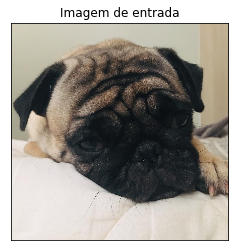

In [8]:
fig0, ax0 = pyplot.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Imagem de entrada")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
pyplot.show()
pyplot.close(fig0)

<p>Podemos verificar as dimensões da imagem através do seguinte comando:</p>

In [9]:
img.shape

(873, 873, 3)

<p>Podemos notar que trata-se de uma imagem de 873x873 pixels, a última dimensão (3) nos indica que é uma imagem colorida.<br>
O próximo passo é gerar os filtros que serão submetidos às camadas convolucionais, neste trabalho submeteremos o mesmo filtro duas vezes para a camada de convolução. Outras abordagens utilizam diferentes filtros à cada convolução.
</p>

In [10]:
#gferando os filtros
fbank = filtergen(num=4,md=0,stdv=0.2,sz=4)


<p>Agora iremos acionar a primeira camada de convolução passando para ela como parâmetros a imagem que importamos e o banco de filtros que geramos, o resultado deste processo será armazenado na variável conv1 (este processo pode ser um pouco demorado):</p>

<h3>3.1 Primeira iteração de Convolução+Pooling</h3>

In [11]:
conv1 = conv(img,fbank)

In [12]:
conv1.shape

(870, 870, 12)

<p>Perceba que foram geradas 12 imagens de 870x870 pixels. Através do código abaixo vizualizaremos as imagens geradas:</p>


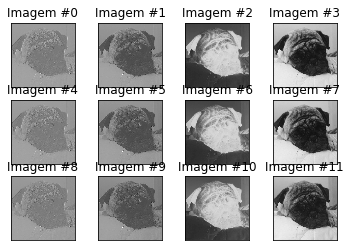

In [13]:
view = conv1
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

<p>Agora submeteremos os resultados da camada de convolução para a camada de pooling e, em seguida, analisaremos os resultados</p>

In [14]:
pool1 = maxpool(conv1)

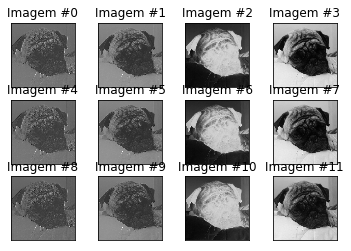

In [15]:
view = pool1
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

In [16]:
pool1.shape

(435, 435, 12)

<p>Perceba que o tamanho das imagens diminuiu, porém existe o mesmo número de imagens. Agora faremos novamente as mesmas duas operações com os resultados obtidos, porém nas próximas visualizações selecionaremos as 12 primeiras imagens, pois será gerado um número muito grande de saídas</p>


<h3>3.2 Segunda iteração de Convolução+Pooling</h3>

In [18]:
conv2 = conv(pool1,fbank)

In [19]:
conv2.shape

(432, 432, 48)

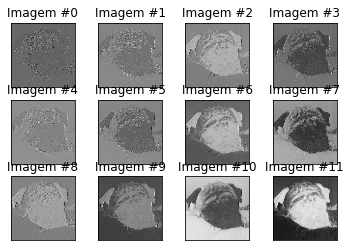

In [23]:

view = conv2
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

In [24]:
pool2 = maxpool(conv2)

In [25]:
pool2.shape

(216, 216, 48)

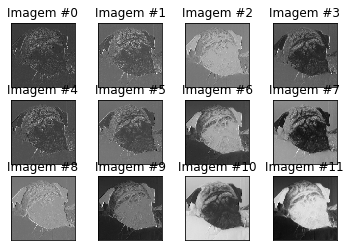

In [27]:

view = pool2
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

<h3>3.3 Camada Completamente Conectada</h3>

<p>Chegamos ao ponto principal deste trabalho que é mostrar a diferença entre a Camada Completamente Conectada que chamamos de 'clássica' e  a moderna. Nossa primeira tarefa será gera um novo banco de filtros para esta camada. O mesmo banco de filtros gerado será 'achatado' e colocado em uma nova variável.</p>

In [28]:
fcl_fbank = np.array(filtergen(4,sz=1)) #para o modo moderno
fcl_fbank_cl = fcl_fbank.reshape(-1) #para o modo clássico

<p>No passo seguinte submeteremos os resultados da camada de pooling anterior (pool2) ao formato moderno da camada completamente conectada, em seguida analisaremos o formato da saída e algumas das imagens geradas</p>

In [29]:
fcc1_moderna = fullyconnV(pool2,fcl_fbank)

In [30]:
fcc1_moderna.shape

(216, 216, 192)

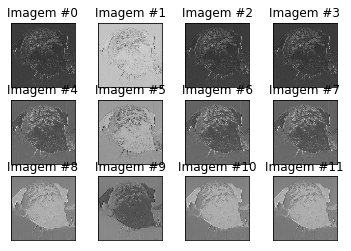

In [31]:
view = fcc1_moderna
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

<p>Perceba que recebemos como saída da camada completamente conectada um vetor de 3 dimensões, contendo 192 matrizes de 216x216 pixels, isso nos dá um total de 8.957.952 parâmetros.<br>
Agora faremos a mesma operação na forma 'clássica' de se fazer uma camada completamente conectada.</p>

In [32]:
fcc1_classica = fullyconnV(pool2,fcl_fbank_cl,mode="classic")

In [33]:
fcc1_classica.shape

(8957952,)

<p>Perceba que temos os mesmos 8.957.952 parâmetros do modo anterior, porém com a diferença é que agora estes parâmetros tem apenas 1 dimensão. Dessa forma não somos capazes de visualizar as imagens geradas por que o resultado não são imagens, e sim um vetor. Para tentar contornar isso iremos fazer novamente o 'reshape' para o formato da saída de camada moderna (216, 216, 192)  e observaremos os resultados
</p>

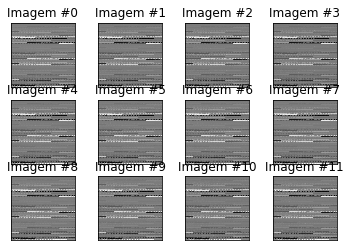

In [37]:
view = fcc1_classica.reshape((216,216,-1))
linhas = 3
colunas = 4
fig0, ax0 = pyplot.subplots(nrows=linhas, ncols=colunas)
i = 0

for l in range(linhas):
    for c in range(colunas):
        ax0[l,c].imshow(view[:,:,i]).set_cmap("gray")
        ax0[l,c].set_title("Imagem #"+str(i))
        ax0[l,c].get_xaxis().set_ticks([])
        ax0[l,c].get_yaxis().set_ticks([])
        i += 1
pyplot.show()
pyplot.close(fig0)

<p>Repare que as imagens que geramos através do 'reshape' não representa nada visualmente, no processo de achatamento antes do processamento perdeu-se informações de localização dos pixels, que, após o processamento, fica muito difícil recuperar. Isso dificulta a análise do aprendizado da rede dentro da camada completamente conectada.
</p>

<h2>Considerações Finais</h2>

<p>Neste trabalho pudemos demonstrar o efeito do achatamento dos dados dentro de uma arquitetura tradicional de uma rede neural convolucionais. Pudemos observar que existe uma perda irreparável neste processo de distorção das matrizes, furtando-nos, inclusive, a capacidade de fazer análise dos dados durante o processamento da rede, anuviando ainda mais a compreensão do aprendizado da rede. </p>
<p>Através da técnica de emulação da camada completamente conectada através de concoluções subdimensionadas evita essa deformação dos dados mantendo os mapas de características por toda a extensão da rede, o que soa interessante principalmente quando pensamos em algoritmos de localização de objetos em que esta relação de visinhança é de extrema importância.
    </p>